In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import urllib
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("data/wsb_interim.csv", index_col=0)

In [3]:
df2 = df[ df['body'].isna() ]

In [4]:
df2[df2.type=='image'].sample(10)['url']

21450      https://i.redd.it/n5lyfnqkdye61.png
36568      https://i.redd.it/434fp1q27hk61.jpg
30994      https://i.redd.it/5pw3hww60wf61.jpg
19915    https://www.reddit.com/gallery/l9c9q4
23208      https://i.redd.it/po8vnem373f61.jpg
18361      https://i.redd.it/c4fpmznogce61.png
15532      https://i.redd.it/lirehs1rj4e61.png
36319      https://i.redd.it/lf3pvft7opj61.jpg
10621      https://i.redd.it/wo0f9daln3e61.jpg
20105      https://i.redd.it/gxnptpno7we61.jpg
Name: url, dtype: object

In [5]:
df2.head()

,title,score,id,url,comms_num,body,timestamp,date,title_raw,body_raw,title_length,title_capital,body_length,body_urls,body_punct,type,deleted,body_bow
0,"['money', 'send', 'message', 'rocket', 'gem_st...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,NaN,2021-01-28 21:37:41,2021-01-28,"It's not about the money, it's about sending a...",NaN,17,0.025000,NaN,0,0,video,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"['Math', 'Professor', 'Scott', 'Steiner', 'say...",110,l6uibd,https://v.redd.it/ah50lyny62e61,23,NaN,2021-01-28 21:32:10,2021-01-28,Math Professor Scott Steiner says the numbers ...,NaN,12,0.180000,NaN,0,0,video,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"['new', 'SEC', 'filing', 'GME', 'retarded', 'i...",29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,NaN,2021-01-28 21:28:57,2021-01-28,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,NaN,15,0.957447,NaN,0,0,other,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['distract', 'GME', 'think', 'AMC', 'brother',...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,NaN,2021-01-28 21:26:56,2021-01-28,"Not to distract from GME, just thought our AMC...",NaN,16,0.137255,NaN,0,0,image,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,['break'],405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84,NaN,2021-01-28 21:26:30,2021-01-28,WE BREAKING THROUGH,NaN,3,1.000000,NaN,0,0,image,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [121]:
import time

path = 'images/'

def download_image(name, url):
    if '.jpg' in url or '.png' in url:
        
        try:
            req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})   

            html = urllib.request.urlopen(req)
            arr = np.asarray(bytearray(html.read()), dtype=np.uint8)
            img = cv2.imdecode(arr, -1)
            cv2.imwrite(path+name+'.jpg', img)
            
        except:
            pass
        
        finally:
            pass

In [20]:
len(df2[ df2['url'].str.contains('.jpg') | df2['url'].str.contains('.png') ])

11097

In [23]:
len(df2[ df2['url'].str.contains('gallery') ])

1093

In [125]:
len(df2[ df2['url'].str.contains('youtube') | df2['url'].str.contains('youtu.be') ])

167

In [126]:
len(df2[ df2['url'].str.contains('twitter') ])

291

In [127]:
len(df2[ df2['url'].str.contains('v.redd') ])

1235

In [21]:
len(df2)

18437

## Download images

In [122]:
from tqdm.notebook import tqdm

for index, row in tqdm(df2.iterrows()):
    download_image(row['id'], row['url'])
    time.sleep(0.1)

# df2.apply(lambda x: download_image(x['id'], x['url']), axis=1)

## OCR Tesseract

In [6]:
from pytesseract import Output
import pytesseract

pytesseract.pytesseract.tesseract_cmd = 'D:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [7]:
def resize(img):
    w = img.shape[1]
    h = img.shape[0]
    
    if w > 400 or h > 400:
        scale_factor = 400 / w if w > h else 400 / h
    else:
        return img
    
    width = int(w * scale_factor)
    height = int(h * scale_factor)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def get_text(path):
    image = cv2.imread(path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pytesseract.image_to_data(rgb, output_type=Output.DICT)
    
    texts = []
    for i in range(0, len(results["text"])):
        text = results["text"][i]
        conf = int(results["conf"][i])
        
        if conf > 50:
            texts.append(text)
            
    return ' '.join(texts)

In [8]:
samp = "images/l6h59b.jpg"
get_text(samp)

'TOP DEFINITION melvin A frontal wedgie. Instead of underpants being up your butt crack, they ride up into the labia. It is not okay to pick your Melvin in public. by October 14, 2014'

In [9]:
directory = "./images"

tess = []
tess_names = []

for idx, filename in enumerate(tqdm(os.listdir(directory))):
    tess.append(get_text(os.path.join(directory, filename)))
    tess_names.append(filename.split('.')[0])

In [10]:
import pickle

with open('backup/ocr_tesseract.pickle', 'wb') as handle:
    pickle.dump(tess, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('backup/ocr_names_tesseract.pickle', 'wb') as handle:
    pickle.dump(tess_names, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
df_ocr = pd.DataFrame(zip(tess_names, tess), columns=["id", "text"])

In [23]:
df_ocr

,id,text
0,l6h59b,TOP DEFINITION melvin A frontal wedgie. Instea...
1,l6h5u6,5:03 7 < Search < History Il History Orders De...
2,l6h5yn,"a) 5G @) Investing Hi Free stock $48,463.62 A ..."
3,l6h61s,"r/wallstreetbets 3,489,124 Degenerates * 741..."
4,l6h7dg,GME Gamestop $318.01 © A $199.53 (134.84%) Tod...
...,...,...
9283,lvukz7,11:12 & NES ull Position Shares Market Value $...
9284,lvumgs,et) AT&T 5GE 11:08 PM < $26.12 RKT Shares Mark...
9285,lvv3h6,‘Symbol AAL AMERICAN AIRLINES GROUP INC COM U....
9286,lvv3h8,4:53 LTE $2.38 < View NIO 1W ALL uly Your Posi...


In [29]:
import spacy
import nltk
import re

from nltk.stem.porter import *

nlp = spacy.load("en_core_web_sm")

TIME = r"\d{1,2}:\d{2}"
EXP = re.compile(TIME)

def lemmatization(x):
    if type(x) == spacy.tokens.doc.Doc:
        return [token.lemma_ for token in x if not token.is_stop and token.is_alpha]
    return x

def type_check(x):
    return type(x) == spacy.tokens.doc.Doc

def get_caps(x):
    if type_check(x):
        caps_perc = 0
        title_len = 0
        for token in x:
            title_len += len(token.shape_)
            caps_perc += token.shape_.count('X')
            
        if title_len != 0:
            return caps_perc / title_len
    return 0.0

def is_twitt(x):
    if 'Twitt' in x:
        return 1
    return 0

def get_features(df):
    df['twitter'] = df['text'].apply(is_twitt)
    df['text'] = df['text'].apply(lambda x: nlp(x))
    df['text_bow'] = df['text'].apply(lemmatization)
    df['text_length'] = df['text'].apply(lambda x: len(x))
    df['text_capital'] = df['text'].apply(get_caps)
    return df

In [30]:
df_ocr_proc = get_features(df_ocr)

In [33]:
df_ocr_proc

,id,text,twitter,text_bow,text_length,text_capital
0,l6h59b,"(TOP, DEFINITION, melvin, A, frontal, wedgie, ...",0,"[definition, melvin, frontal, wedgie, instead,...",39,0.100000
1,l6h5u6,"(5:03, 7, <, Search, <, History, Il, History, ...",0,"[search, history, Il, history, Orders, Deposit...",41,0.151079
2,l6h5yn,"(a, ), 5, G, @, ), Investing, Hi, Free, stock,...",0,"[g, invest, hi, free, stock, Past, Week, M, M,...",54,0.155844
3,l6h61s,"( , r, /, wallstreetbets, 3,489,124, Degenera...",0,"[r, wallstreetbet, Degenerates, buying, fd, Me...",105,0.176829
4,l6h7dg,"(GME, Gamestop, $, 318.01, ©, A, $, 199.53, (,...",0,"[GME, gamestop, today, Vv, Hours, position, Sh...",46,0.140244
...,...,...,...,...,...,...
9283,lvukz7,"(11:12, &, NES, ull, Position, Shares, Market,...",0,"[NES, ull, Position, Shares, market, Value, Av...",44,0.122581
9284,lvumgs,"(et, ), AT&T, 5GE, 11:08, PM, <, $, 26.12, RKT...",0,"[et, pm, RKT, share, Market, Value, Avg, Cost,...",78,0.155738
9285,lvv3h6,"(‘, Symbol, AAL, AMERICAN, AIRLINES, GROUP, IN...",0,"[Symbol, AAL, AMERICAN, AIRLINES, GROUP, INC, ...",72,0.202128
9286,lvv3h8,"(4:53, LTE, $, 2.38, <, View, NIO, 1W, ALL, ul...",0,"[LTE, View, NIO, uly, Position, Equity, NIO, B...",57,0.191489


In [35]:
from collections import Counter

def get_vocab(data, n):
    words = Counter()
    for i in data.index:
        words.update(data.at[i])

    return words

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0:'Token', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

In [39]:
df_ocr_proc['text_bow'] = df_ocr_proc['text_bow'].fillna(value='')
vocab = get_vocab(df_ocr_proc['text_bow'], 1000)

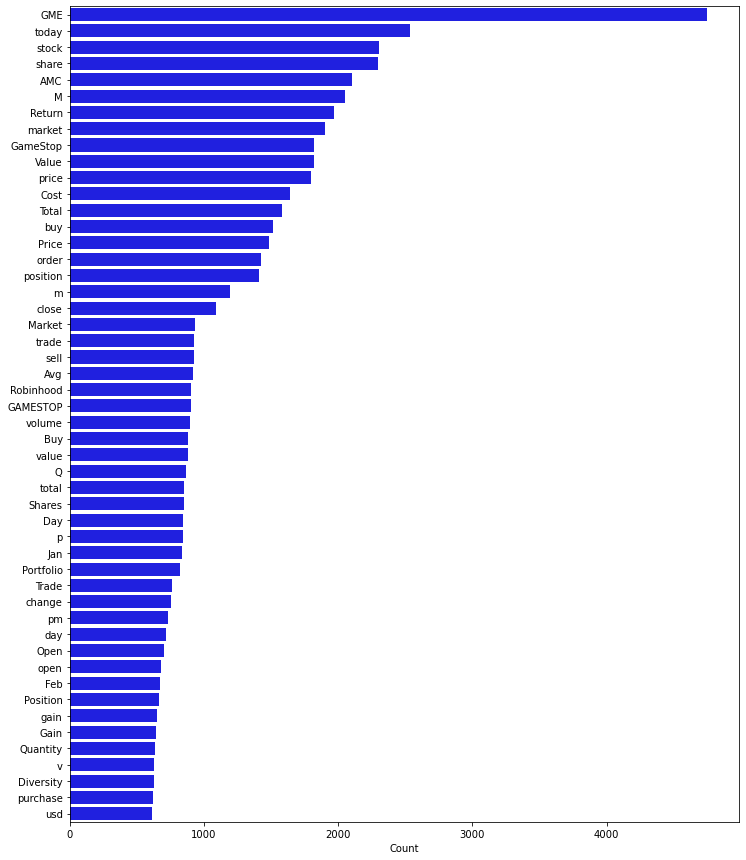

In [41]:
show_histogram(vocab.most_common(50))

In [42]:
def bag_of_words(x, most_freq):
    sent_vec = []
    for token in most_freq:
        if token in x:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    return sent_vec

In [44]:
feature_dict = [key for key, _ in vocab.most_common(200)]

df_ocr_proc['text_bow'] = df_ocr_proc['text_bow'].apply(lambda x: bag_of_words(x, feature_dict))

In [46]:
df_ocr_proc = df_ocr_proc.drop("text", axis=1)
df_ocr_proc.head()

,id,twitter,text_bow,text_length,text_capital
0,l6h59b,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",39,0.100000
1,l6h5u6,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41,0.151079
2,l6h5yn,0,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",54,0.155844
3,l6h61s,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",105,0.176829
4,l6h7dg,0,"[1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, ...",46,0.140244


## Color Palette

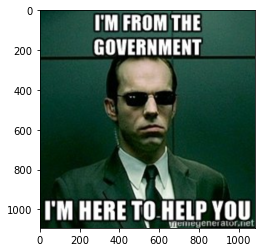

In [29]:
im = imgload(df2['url'][18])
plt.imshow(im)

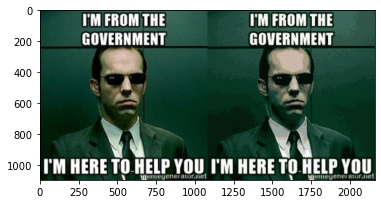

In [30]:
from sklearn.cluster import MiniBatchKMeans

(h, w) = im.shape[:2]
image = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = MiniBatchKMeans(n_clusters = 16)
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

quant = quant.reshape((h, w, 3))
image = image.reshape((h, w, 3))

quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)

plt.imshow(np.hstack([image, quant]))

In [72]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_palette(img):
    palette = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    palette_colors = np.unique(palette, return_counts=True, axis=0)
    hex_palette = np.apply_along_axis(RGB2HEX, 1, palette_colors[0])
    palette_tup = zip(hex_palette.tolist(), palette_colors[1].tolist())
    sorted_tup = sorted(palette_tup, key=lambda x: x[1], reverse=True)    
    return [color[0] for color in sorted_tup]

In [73]:
pal = get_palette(quant)
pal

['#073625',
 '#042c19',
 '#164234',
 '#204d40',
 '#020d05',
 '#051d0d',
 '#305648',
 '#f8fbfa',
 '#396658',
 '#c9b7aa',
 '#62604d',
 '#7f8377',
 '#30312a',
 '#99a5a0',
 '#cdd6d0',
 '#a69b7e']

In [109]:
from sklearn.cluster import MiniBatchKMeans

def quantize(im):
    (h, w) = im.shape[:2]
    image = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

    image = image.reshape((image.shape[0] * image.shape[1], 3))

    clt = MiniBatchKMeans(n_clusters = 8)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]
    quant = quant.reshape((h, w, 3))
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
    
    return quant

#def RGB2HEX(color):
#    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_closest_color(color):
    min_colors = {}
    if colors is not None:
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - color[0]) ** 2
            gd = (g_c - color[1]) ** 2
            bd = (b_c - color[2]) ** 2
            min_colors[(rd + gd + bd)] = name
        return min_colors[min(min_colors.keys())]
    return color

def get_palette(img):
    img = quantize(img)
    palette = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    palette_colors = np.unique(palette, return_counts=True, axis=0)
    #hex_palette = np.apply_along_axis(RGB2HEX, 1, palette_colors[0])
    hex_palette = np.apply_along_axis(get_closest_color, 1, palette_colors[0])
    palette_tup = zip(hex_palette.tolist(), palette_colors[1].tolist())
    sorted_tup = sorted(palette_tup, key=lambda x: x[1], reverse=True)    
    return [color[0] for color in sorted_tup]

In [110]:
directory = "./images"

width = 100
height = 100
dim = (width, height)
colors = []
color_names = []

for idx, filename in enumerate(tqdm(os.listdir(directory))):
    im = cv2.imread(os.path.join(directory, filename))
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
 
    # resize image
    resized = cv2.resize(im_rgb, dim, interpolation = cv2.INTER_AREA)
    
    colors.append(get_palette(resized))
    color_names.append(filename.split('.')[0])

In [111]:
col_names = [f"col{x}" for x in range(8)]

In [117]:
colors_df = pd.DataFrame(colors, columns=col_names)

In [118]:
id_col = pd.DataFrame(color_names, columns=['id'])

In [119]:
df_colors = pd.concat([id_col, colors_df], axis=1)
df_colors

,id,col0,col1,col2,col3,col4,col5,col6,col7
0,l6h59b,white,darkgray,white,lightgray,lavender,steelblue,whitesmok,palegolde
1,l6h5u6,black,black,black,darks,darks,dimgr,black,gray
2,l6h5yn,black,black,black,darks,dimgr,darks,darkg,black
3,l6h61s,black,darkslat,darkslat,lightsla,lightste,slategra,darkcyan,sienna
4,l6h7dg,black,black,limeg,darkg,dimgr,darks,fores,light
...,...,...,...,...,...,...,...,...,...
9283,lvukz7,black,black,limeg,darks,darkg,green,gray,black
9284,lvumgs,black,black,black,limeg,dimgr,darks,darks,darks
9285,lvv3h6,white,lavender,lightgray,lightgray,silver,darkgray,lightslat,slategray
9286,lvv3h8,black,black,limeg,darks,dimgr,dimgr,darkg,fores


In [147]:
df_colors.to_csv("backup/colors.csv", index=False)

## Feature extraction

In [149]:
import os
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Model

In [147]:
model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 15s 0us/step


In [148]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [150]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

shape of x:  (1, 224, 224, 3)
data type:  float32


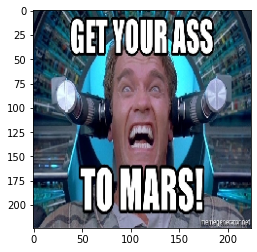

In [155]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

img, x = load_image("images/l6hez2.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

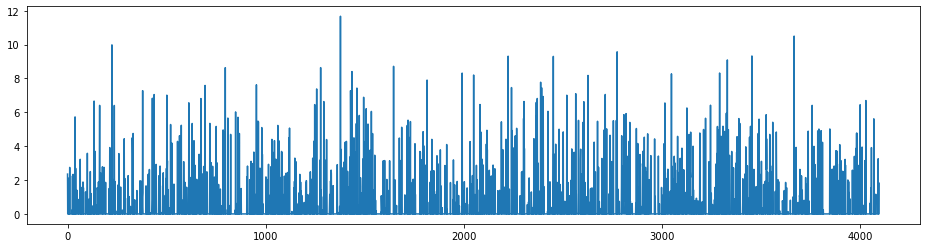

In [156]:
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [166]:
directory = "./images"
features = []
names = []

for idx, filename in enumerate(os.listdir(directory)):
    if idx % 1000 == 0:
        print("analyzing image %d" % (idx))
    img, x = load_image(os.path.join(directory, filename))
    feat = feat_extractor(x, training=False)[0]
    
    features.append(feat)
    names.append(filename.split('.')[0])

analyzing image 0
analyzing image 1000
analyzing image 2000
analyzing image 3000
analyzing image 4000
analyzing image 5000
analyzing image 6000
analyzing image 7000
analyzing image 8000
analyzing image 9000


In [167]:
import pickle

with open('backup/visual_features.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [168]:
with open('backup/visual_names.pickle', 'wb') as handle:
    pickle.dump(names, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load from pickle

In [47]:
with open('backup/visual_features.pickle', 'rb') as handle:
    features = pickle.load(handle)
    
with open('backup/visual_names.pickle', 'rb') as handle:
    names = pickle.load(handle)

In [48]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=100)
pca.fit(features)

PCA(n_components=100)

In [49]:
print(pca.explained_variance_ratio_)

[0.15806225 0.14667782 0.05926112 0.04185057 0.03336001 0.03154228
 0.0288671  0.02076798 0.01614328 0.01368907 0.01159926 0.0114409
 0.01057978 0.00984633 0.00937482 0.00914085 0.00793621 0.00740097
 0.00699911 0.00626585 0.0060645  0.00553842 0.00548509 0.00500173
 0.00462009 0.0045286  0.00436103 0.004221   0.00412025 0.00386861
 0.00384966 0.00368264 0.0036128  0.00348824 0.00340783 0.00325111
 0.00312789 0.00304941 0.00292309 0.00287598 0.0028005  0.00272877
 0.00258761 0.00252106 0.00247457 0.00241664 0.00231571 0.00226119
 0.00225425 0.00219348 0.00211557 0.00203397 0.00203054 0.00201256
 0.00196065 0.00186201 0.00182955 0.00179655 0.00177041 0.00175171
 0.00170409 0.00168043 0.00164794 0.00157098 0.00156416 0.00155405
 0.00152929 0.00150738 0.00146504 0.00144694 0.00143191 0.00140684
 0.00138745 0.00134201 0.0013276  0.00129585 0.00127808 0.00122816
 0.0012187  0.00121024 0.00120686 0.00118585 0.00115393 0.00113828
 0.00111964 0.00110439 0.00108994 0.00108411 0.00106528 0.00105

In [50]:
pca_features = pca.transform(features)

In [51]:
with open('backup/visual_pca_features.pickle', 'wb') as handle:
    pickle.dump(pca_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
pca_features

array([[-8.4223375e+00, -1.9676991e+01, -1.0379639e+01, ...,
         1.3933837e+00,  1.7304167e-01,  3.7902659e-01],
       [ 9.8699274e+00,  1.2391532e+01, -2.0306280e+01, ...,
         2.0603554e+00,  3.9347100e-01, -3.3318624e-02],
       [ 1.0384289e+01,  4.5272537e+01,  1.4475423e+01, ...,
        -5.9355962e-01,  3.5393682e-01,  5.5370784e-01],
       ...,
       [-8.4813194e+00, -1.0502664e+01,  1.3869986e+01, ...,
         3.7766653e-01,  2.8472598e+00, -6.0659695e-01],
       [ 1.6364956e+01,  3.2017372e+01,  8.9522181e+00, ...,
        -8.1062603e-01, -6.2607452e-02,  2.6379564e-01],
       [ 8.2750368e+00,  1.7731743e+01, -4.8195391e+00, ...,
         1.6569052e+00,  2.9792511e-01, -7.9444951e-01]], dtype=float32)

In [53]:
pca_features_reduced = pca_features[:13]

In [54]:
pca_features_reduced

array([[-8.4223375e+00, -1.9676991e+01, -1.0379639e+01, ...,
         1.3933837e+00,  1.7304167e-01,  3.7902659e-01],
       [ 9.8699274e+00,  1.2391532e+01, -2.0306280e+01, ...,
         2.0603554e+00,  3.9347100e-01, -3.3318624e-02],
       [ 1.0384289e+01,  4.5272537e+01,  1.4475423e+01, ...,
        -5.9355962e-01,  3.5393682e-01,  5.5370784e-01],
       ...,
       [ 3.3628349e+01, -3.0868561e+01,  1.0304584e+01, ...,
         3.4938073e-01,  1.3997266e+00, -1.9115834e+00],
       [-4.8541766e-01,  1.0523702e+01, -3.2929119e+01, ...,
        -3.3402884e-01, -1.7987402e-01,  2.0778880e+00],
       [ 1.2116126e+01, -9.4647751e+00, -1.3068652e+01, ...,
         1.5690652e+00, -3.2449341e-01, -1.0086036e+00]], dtype=float32)